<a href="https://colab.research.google.com/github/xychong/miniproject/blob/main/No_Data_Augmentation_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
print(tf.__version__)

2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_path = "/content/drive/MyDrive/Data/train"
train_path_cat = "/content/drive/MyDrive/Data/train/cat"
train_path_dog = "/content/drive/MyDrive/Data/train/dog"

val_path = "/content/drive/MyDrive/Data/val"
val_path_cat = "/content/drive/MyDrive/Data/val/cat"
val_path_dog = "/content/drive/MyDrive/Data/val/dog"

test_path = "/content/drive/MyDrive/Data/test/"

In [5]:
#train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(150,150),
                                                  batch_size = 32,
                                                  class_mode = 'binary')

val_dataset = val_datagen.flow_from_directory(val_path,
                                              target_size=(150,150),
                                              batch_size = 32,
                                              class_mode = 'binary')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(150, 150, 3))
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
model = keras.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer 
        keras.layers.Flatten(),
        #keras.layers.Dropout(0.50),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.20),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.10),         
        keras.layers.Dense(1, activation='sigmoid')    
    ])

# Unfreeze the base model
vgg_base.trainable = True

# Observe how many layers are in the base model
# 19
print("Number of layers in the base model: ", len(vgg_base.layers))

# Fine-tune from this layer onwards
fine_tune_at = 16

# Freeze all layers before 'fine_tune_at' layer
for layer in vgg_base.layers[:fine_tune_at]:
  layer.trainable = False

for layer in vgg_base.layers:
  print(layer, layer.trainable)

Number of layers in the base model:  19
<keras.engine.input_layer.InputLayer object at 0x7f4cf56fd350> False
<keras.layers.convolutional.Conv2D object at 0x7f4d50154fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf4ee4fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4cf4690110> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf4689b10> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf430acd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4cf4314e90> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf431d110> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf431ac10> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf43246d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4cf432c6d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf4326a10> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf4314cd0> False
<keras.layers.convolutional.Conv2D object at 0x7f4cf4339610> False
<keras.layers.poolin

In [9]:
# Adjust the learning rate of Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt ,loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [11]:
train_steps = train_dataset.n // 32
val_steps = val_dataset.n // 32

print(train_steps)
print(val_steps)

100
25


In [12]:
training = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=10, validation_data=val_dataset, validation_steps=val_steps)

Epoch 1/10
100/100 [==============================] - 31s 243ms/step - loss: 0.2939 - accuracy: 0.8722 - val_loss: 0.1946 - val_accuracy: 0.9162
Epoch 2/10
100/100 [==============================] - 24s 241ms/step - loss: 0.1338 - accuracy: 0.9494 - val_loss: 0.1659 - val_accuracy: 0.9250
Epoch 3/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0651 - accuracy: 0.9781 - val_loss: 0.2684 - val_accuracy: 0.9062
Epoch 4/10
100/100 [==============================] - 24s 242ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.3574 - val_accuracy: 0.9075
Epoch 5/10
100/100 [==============================] - 24s 243ms/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0.2783 - val_accuracy: 0.9225
Epoch 6/10
100/100 [==============================] - 24s 242ms/step - loss: 0.0276 - accuracy: 0.9903 - val_loss: 0.2651 - val_accuracy: 0.9275
Epoch 7/10
100/100 [==============================] - 24s 240ms/step - loss: 0.0132 - accuracy: 0.9969 - val_loss: 0.2870 - val_ac

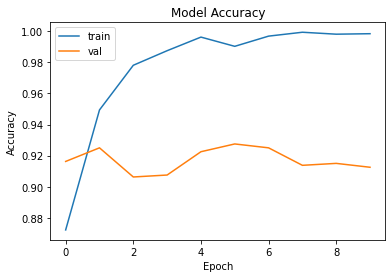

In [13]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

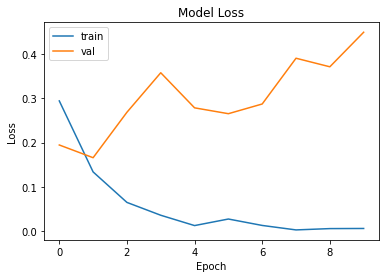

In [14]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
submission = pd.DataFrame(columns=['id','label'])
submission

,id,label


In [16]:
test_label = []
count = 0
for filename in os.listdir(test_path):
  first_word = filename.split('.')[0]
  img = image.load_img(test_path + filename, target_size = (150,150)) # load and resize image as 150x150
  Y = image.img_to_array(img) # convert image into a numpy array 
  X = np.expand_dims(Y,axis=0) # expand the dimension of that array
  val = model.predict(X)
  test_label.append(int(val))
  submission = submission.append({'id': int(first_word),'label': int(val)}, ignore_index=True)
  count += 1

print(test_label)

[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 

In [17]:
submission
submission.to_csv('/content/drive/MyDrive/Data/submission10_noaug.csv')  

In [18]:
sorted_submission = submission.sort_values('id')
sorted_submission
sorted_submission.to_csv('/content/drive/MyDrive/Data/sorted_submission10_noaug.csv')  

In [19]:
sorted_submission

,id,label
466,1,0
431,2,1
459,3,1
345,4,1
376,5,1
...,...,...
315,496,1
337,497,1
164,498,0
151,499,1
